# Weak instruments

We've all heard that the rule of thumb for strong instruments is $F > 10$ (though troubling [recent work](https://arxiv.org/pdf/2010.05058.pdf) suggests that F might need to be much, much larger...). Let's explore in code the weak instruments problem, by examining the bias and precision of IV estimates in the just-identified case.

First, we need to specify data-generating processes. Taking notation from the problem set, we want to set up a system that looks like:

$$y = \alpha + \beta x + e$$

$$x = Z\pi + u$$

where $x$ is a scalar variable and $Z$ is $N\times l$.

In [1]:
import numpy as np
import scipy.stats.distributions as iid
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
# DGP: y, x
def dgp(N, beta, pi):
    '''
    Data-generating process
    
    Inputs
    ------
    N (int) number of obervations
    beta (float) true parameter
    pi (lx1 np.array) tur first stage parameter
    
    Returns
    -------
    y (Nx1 np.array)
    x (Nx1 np.array)
    Z (Nxl np.array)
    '''
    # infer number of instruments from the size of pi
    l = pi.shape[0]
    # first generate Z
    Z = scipy.stats.multivariate_normal(np.zeros(l), np.eye(l)).rvs(size=N)
    if len(Z.shape) == 1:
        Z = Z.reshape(-1,1)
    
    # now build X
    X = Z@pi + iid.norm().rvs(size=(N,1))

    # finally, build y
    y = X*beta + iid.norm().rvs(size=(N,1))
    
    return y, X, Z

In [ ]:
# test
N = 5
beta = 2
pi = 
dgp(N, beta, pi)

In [4]:
# test IV regression
N = 100
beta = 2

for p in [0.00001, 0.001, 0.1, 1, 500]:
    # set pi
    pi = np.array([[p]])
    # generate data
    y, X, Z = dgp(N, beta, pi)
    # estimate beta via IV
    bhat = np.linalg.solve(Z.T@X, Z.T@y) 
    # report
    print(f'beta_hat for pi = {p}: {bhat.item():.4}')

beta_hat for pi = 1e-05: 2.143
beta_hat for pi = 0.001: 3.59
beta_hat for pi = 0.1: 10.26
beta_hat for pi = 1: 1.846
beta_hat for pi = 500: 2.0


### Check your understanding
1. If I estimate beta via OLS given this DGP will it be biased? Why or why not?
2. Why don't I need an intercept in these regressions?

Let's write a two-stage least squares function to do this systematically. We want to do 2SLS because in the future we may want more instruments.

In [5]:
def two_sls(y, X, Z):
    '''
    Estimate 2 stage least squares given data on y, X and Z.
    
    Inputs:
    -------
    y (Nx1 np.array)
    X (Nx1 np.array)
    Z (Nxl np.array)
    
    Returns
    -------
    beta_hat
    '''
    xhat = X@np.linalg.solve(Z.T@Z, Z.T@X)
    beta_hat = np.linalg.solve(xhat.T@xhat, xhat.T@y)
    return beta_hat

In [6]:
# test 
y, X, Z = dgp(1000, 1, np.array([[1]]))
two_sls(y, X, Z) # looks close!

array([[0.94084952]])

In [7]:
# wrapping everything up in one function
def monteCarlo(N, beta, pi):
    y, X, Z = dgp(N, beta, pi)
    return two_sls(y, X, Z)

## Iterating

Now that we have a DGP, let's set up a Monte Carlo simulation to see how it performs. First, we'll choose specific values for $\beta$ and $\pi$, say $\beta=\pi=1$. Let's first say we want to compare 3 dataset sizes: N=100, N=1000, and N=10000. For each, we want to plot the distribution of the IV estimator. To do this, our code will look like:

```
for N in [100, 1000, 10000]:
    for a bunch of times:
        create data of size N
        estimate IV using that data
    plot histogram
```

First, I want to get in the weeds a bit about using the plotting package in python, ``matplotlib``. We've used it a bunch but I haven't yet explained it. We can think of matplotlib graphs as being composed of 3 elements:
1. The figure. This is a container that holds all the rest of the plot; it is the first thing we need to initialize.
2. The axes. These contain regions for plotting; a figure can have one axis or many axes. 
3. The Artist. Everything else you see on the plot is part of the artist- the lines, points, grid, etc. 

My personal preferred method for starting a matplotlib plot is to instantiate the figure and axes together using the plt.subplots() syntax (you can use this for just 1 "subplot" too, so it's very general!

```
fig, ax = plt.subplots(nrows, ncolumns, ...other args...)
```

with this syntax, I've named the figure ``fig`` and the axes ``ax``. In the case of multiple subplots, this axes is iterable and subsettable, so ``ax[0]`` is the first plotting region, and ``ax[1]`` is the second, and so forth. Let's see a simple example with two trivial plots before applying this to our objective.


Text(0.5, 1.0, 'Mean 10 data')

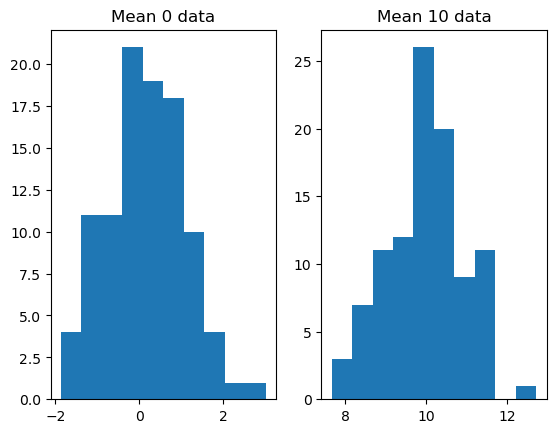

In [8]:
# make two histograms
data1 = iid.norm().rvs(size=100)
data2 = iid.norm(loc=10).rvs(size=100)

# initialize figure, axes
fig, ax = plt.subplots(1, 2)
# plot in first region
ax[0].hist(data1)
# plot in 2nd region
ax[1].hist(data2)

# add subtitles
ax[0].set_title("Mean 0 data")
ax[1].set_title("Mean 10 data")

Now back to our task. We will want to initialize 3 subplots, one for each N. I'll use a ``counter`` that I add 1 to in each iteration to move along these axes as we do our calculations.

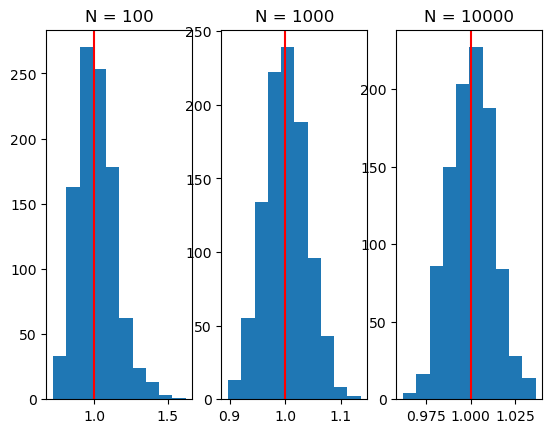

In [14]:
counter = 0 # first axis starts at 0
fig, ax = plt.subplots(1, 3) # initialize 3 subplots

# set global parameters for DGP
beta = 1
pi = np.array([[1]])

for N in [100, 1000, 10000]:
    # calculate IV a bunch of times
    beta_hats = [monteCarlo(N, beta, pi).item() for i in range(1000)]
    # plot
    ax[counter].hist(beta_hats)
    ax[counter].set_title(f"N = {N}")
    ax[counter].axvline(x=1, color='r', label='True beta')

    # advance counter
    counter = counter + 1

# Actually weak instruments
Now let's iterate over $\pi$ instead of N, seeing how we do with varyingly weak instruments.

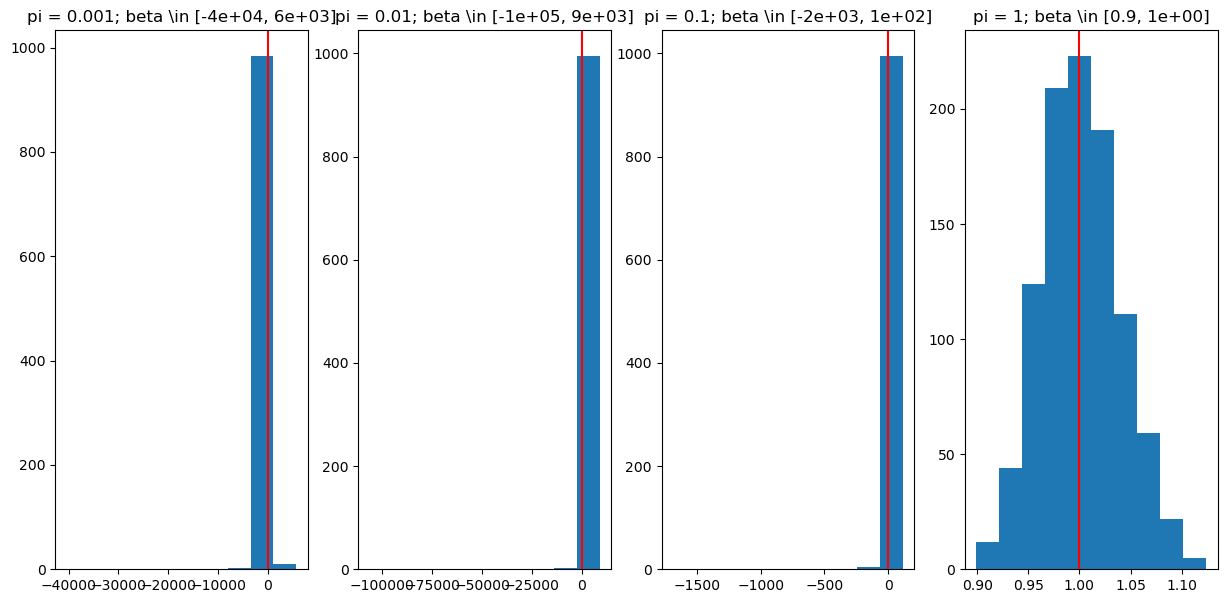

In [22]:
counter = 0 # first axis starts at 0
fig, ax = plt.subplots(1, 4, figsize=(15,7)) # initialize 3 subplots

# set global parameters for DGP
beta = 1
N = 1000

# start empty list to save to
beta_hats = []

for p in [0.001, 0.01, 0.1, 1]:
    # calculate IV a bunch of times
    beta_hats = np.array([monteCarlo(N, beta, np.array([[p]])).item() for i in range(1000)])
    # some stats
    minbeta = beta_hats.min()
    maxbeta = beta_hats.max()
    # plot
    ax[counter].hist(beta_hats)
    ax[counter].set_title(f"pi = {p}; beta \in [{minbeta:.1}, {maxbeta:.1}]")
    ax[counter].axvline(x=1, color='r', label='True beta')

    # advance counter
    counter = counter + 1